In [1]:
import os
import cv2
import numpy as np
import pandas as pd

from insightface.app import FaceAnalysis

C:\Users\tanya\OneDrive\Desktop\Face Recognition Attendance System - Copy - Copy\Attendance_System\Notes\attendance_system\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# configure face analysis
faceapp = FaceAnalysis(name='buffalo_l', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


### Extract facial features and labels

In [3]:
# regular expression
import re

In [4]:
# fn to remove any hypen or special char between the first & last name
def clean_name(string):
    string = re.sub(r'[^A-Za-z]',' ', string)
    string = string.title()
    return string

# clean_name('chris_evans')

In [5]:
# Return a list containing the names of the files in the directory.
# os.listdir()

# Return a list inside images folder containing the names of the files in the directory.
# os.listdir(path='images')
# os.listdir(path='images/student-Angelina Jolie')
person_info = []
listdir = os.listdir(path='images')


# 0 - role, 1 - name
for folder_name in listdir:
    print(f"Processing folder: {folder_name}")
    role, name = folder_name.split('-')
    name = clean_name(name);
    role = clean_name(role)
    # print('role :', role, end='\t')
    # print('name :', name)

    # path of each folder in respective folder
    img_files = os.listdir(path=f'images/{folder_name}')
    # print(img_files)
    for file in img_files:
        path = f'./images/{folder_name}/{file}'
        # print(path)

        # step-1 : read the image
        img_arr = cv2.imread(path)

        # step-2 : get the info
        result = faceapp.get(img_arr, max_num=1); # return lists
        # print(result[0].keys())
        # print(result)
        
        if len(result) > 0:
            # step-3 : extract facial embedding
            res = result[0]
            # print(res.keys())
            embedding = res['embedding']
            # step-4 : save all info, name, role, embedding in a list
            person_info.append([name, role, embedding])


Processing folder: student-Aaron_Peirsol
Processing folder: student-Abdullah
Processing folder: student-abhay
Processing folder: student-Aditi
Processing folder: student-adnan
Processing folder: student-Aisvarrya
Processing folder: student-Alastair_Campbell
Processing folder: student-Alec_Baldwin
Processing folder: student-Ali_Naimi
Processing folder: student-Allyson_Felix
Processing folder: student-Alvaro_Uribe
Processing folder: student-Amanda_Bynes
Processing folder: student-Amelia_Vega
Processing folder: student-Amelie_Mauresmo
Processing folder: student-ankita
Processing folder: student-ankur
Processing folder: student-asit
Processing folder: student-Ayusha
Processing folder: student-Barbara_Walters
Processing folder: student-Bashar_Assad
Processing folder: student-Benazir_Bhutto
Processing folder: student-Ben_Affleck
Processing folder: student-Bertie_Ahern
Processing folder: student-Bill_Clinton
Processing folder: student-Bill_Frist
Processing folder: student-Binyamin_Ben
Process

In [6]:
# The name, role, embedding is inside the person_info array
# print(person_info)

# table to see data easily
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])

# store in redis
dataframe

# for idx, se in enumerate(dataframe["Facial_Features"]):
#     print(f"Index: {idx}, Type: {type(se)}, Length: {len(se) if hasattr(se, '__len__') else 'N/A'}")


,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[-0.36875662, -1.6064843, 1.2511821, -0.399673..."
1,Aaron Peirsol,Student,"[-0.0011554584, -1.368503, -0.047049314, 0.508..."
2,Aaron Peirsol,Student,"[0.792392, -0.78379166, 0.58785343, 0.96419513..."
3,Aaron Peirsol,Student,"[0.118267804, 0.222576, 0.58508193, -0.4207472..."
4,Abdullah,Student,"[0.63822305, 0.2289042, -0.31736904, -0.791751..."
...,...,...,...
523,Kevin Costner,Teacher,"[0.29962462, -0.19945751, 1.0537453, 1.3018793..."
524,Kevin Costner,Teacher,"[0.11820501, 0.4532351, -0.01092504, 0.8051185..."
525,Kevin Costner,Teacher,"[-0.012068391, -6.970763e-05, 0.55693746, 0.55..."
526,Kevin Costner,Teacher,"[0.8007083, 0.019446418, 1.3690064, -0.0333238..."


### INFERENCE STAGE

NEW PERSON IMAGE  -> FEATURE EXTRACTION -> MACHINE LEARNING SEARCH ALGO -> PERSON NAME

1. Take new person image
2. Extract feature from the image
3. apply ml search algo in db & extract person name 

### Step-1 : Read test image (TEST IMAGE SINGLE)

In [7]:
# img_test = cv2.imread('test_images/test_2.jpeg')
img_test = cv2.imread('test_images/ankur_test.jpg')

cv2.imshow('ankur test', img_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Step-2 : Extract the features 

In [9]:
res_test = faceapp.get(img_test, max_num=0)
# print(result_test)

for i,rt in enumerate(res_test):
    print('current loop =',i)
    bbox = rt['bbox'].astype(int)
    score = int(rt['det_score']*100)
    embed_test = rt['embedding']
    

current loop = 0


In [10]:
# ONLY 1 SAMPLE IMAGE (no of dimensions in 1 image)
len(embed_test)

512

### Compare the test image facial embedding with all facial embedding avl inside the dataframe

In [11]:
dataframe.head()

,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[-0.36875662, -1.6064843, 1.2511821, -0.399673..."
1,Aaron Peirsol,Student,"[-0.0011554584, -1.368503, -0.047049314, 0.508..."
2,Aaron Peirsol,Student,"[0.792392, -0.78379166, 0.58785343, 0.96419513..."
3,Aaron Peirsol,Student,"[0.118267804, 0.222576, 0.58508193, -0.4207472..."
4,Abdullah,Student,"[0.63822305, 0.2289042, -0.31736904, -0.791751..."


In [12]:
# convert list to array
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)

print(f"x.shape: {X.shape}")

x.shape: (528, 512)


In [13]:
# each 50 samples has 512 dimensions
X.shape

(528, 512)

In [14]:
from sklearn.metrics import pairwise

In [15]:
# euclidean , manhattan distance, cosine similarity

y = embed_test.reshape(1, 512) # reshape to row vector, 1 * 512

equlidean_distance = pairwise.euclidean_distances(X, y)
manhattan_distance = pairwise.manhattan_distances(X, y)
cosine_similar = pairwise.cosine_similarity(X, y)

In [16]:
data_search = dataframe.copy()
data_search['equlidean'] = equlidean_distance
data_search['manhattan'] = manhattan_distance
data_search['cosine'] = cosine_similar

In [17]:
data_search

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Aaron Peirsol,Student,"[-0.36875662, -1.6064843, 1.2511821, -0.399673...",34.908279,626.991205,-0.037387
1,Aaron Peirsol,Student,"[-0.0011554584, -1.368503, -0.047049314, 0.508...",34.127148,614.519193,-0.020184
2,Aaron Peirsol,Student,"[0.792392, -0.78379166, 0.58785343, 0.96419513...",33.000774,591.832524,-0.040231
3,Aaron Peirsol,Student,"[0.118267804, 0.222576, 0.58508193, -0.4207472...",32.729618,584.139075,0.074894
4,Abdullah,Student,"[0.63822305, 0.2289042, -0.31736904, -0.791751...",34.142910,619.832272,0.001618
...,...,...,...,...,...,...
523,Kevin Costner,Teacher,"[0.29962462, -0.19945751, 1.0537453, 1.3018793...",31.851591,576.389880,0.048388
524,Kevin Costner,Teacher,"[0.11820501, 0.4532351, -0.01092504, 0.8051185...",32.416153,586.379848,0.000574
525,Kevin Costner,Teacher,"[-0.012068391, -6.970763e-05, 0.55693746, 0.55...",31.353462,563.916758,0.049395
526,Kevin Costner,Teacher,"[0.8007083, 0.019446418, 1.3690064, -0.0333238...",30.985430,549.518814,0.018415


In [18]:
import matplotlib.pyplot as plt

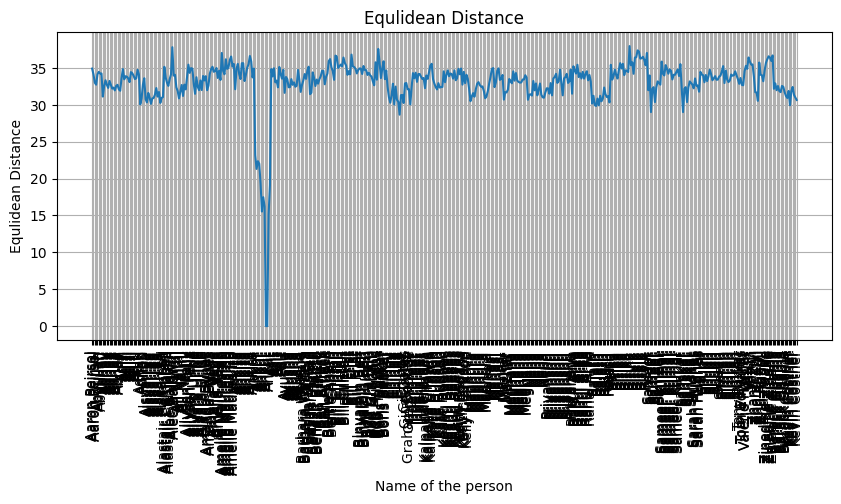

In [19]:
# Equlidean
# X axis : row no / record no
# Y axis : distance

plt.figure(figsize=(10,4))
plt.plot(data_search['equlidean'])
plt.xticks(ticks=list(range(len(data_search['equlidean']))), labels=data_search['Name'], rotation=90)
plt.title("Equlidean Distance")
plt.xlabel('Name of the person')
plt.ylabel('Equlidean Distance')

plt.grid()
plt.show()

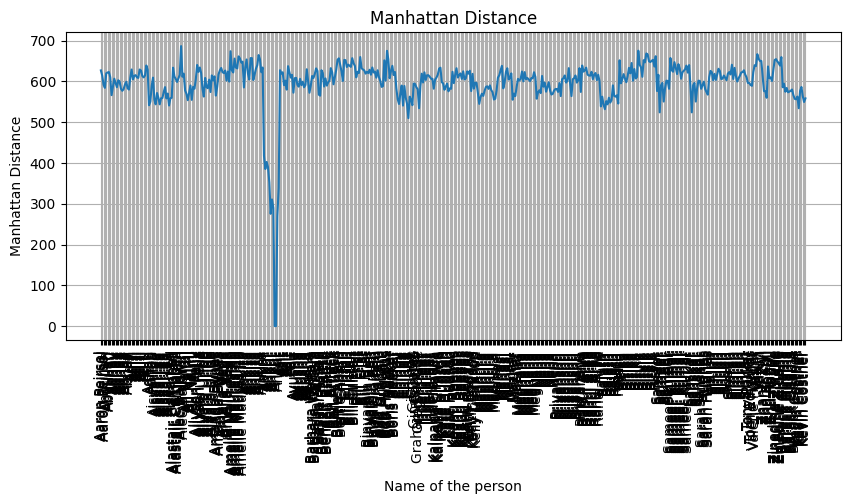

In [20]:
# Manhattan distance
# X axis : row no / record no
# Y axis : distance

plt.figure(figsize=(10,4))
plt.plot(data_search['manhattan'])
plt.xticks(ticks=list(range(len(data_search['manhattan']))), labels=data_search['Name'], rotation=90)
plt.title("Manhattan Distance")
plt.xlabel('Name of the person')
plt.ylabel('Manhattan Distance')

plt.grid()
plt.show()

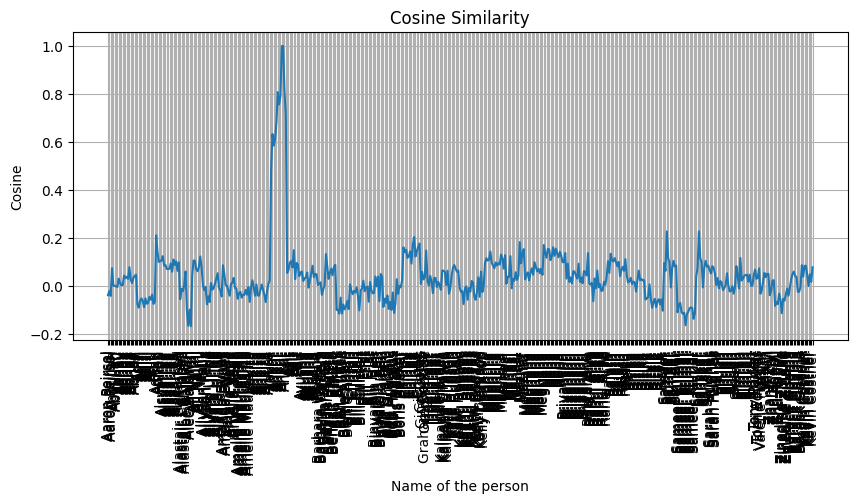

In [21]:
# Cosine Similarity
# X axis : row no / record no
# Y axis : distance

plt.figure(figsize=(10,4))
plt.plot(data_search['cosine'])
plt.xticks(ticks=list(range(len(data_search['cosine']))), labels=data_search['Name'], rotation=90)
plt.title("Cosine Similarity")
plt.xlabel('Name of the person')
plt.ylabel('Cosine')

plt.grid()
plt.show()

## Finding person name using Equilidean distance
- Threshold point afer analysing the graph : **24**
- The data points having distance < 24 will be considered similar

In [22]:
# optimal distance
d_eq_optimal = 24

In [23]:
# filtering data which have distance < 24
datafilter = data_search.query(f'equlidean < {d_eq_optimal} ')
datafilter.reset_index(drop=True, inplace=True)
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Ankur,Student,"[0.7779857, -0.03811796, 1.1893519, 0.05837321...",23.169655,417.621614,0.483628
1,Ankur,Student,"[2.1729677, 2.4065566, 0.4054818, 1.3251727, -...",21.307894,385.243934,0.633745
2,Ankur,Student,"[1.1897379, 1.0526358, 0.10993977, 0.7051736, ...",22.354883,402.518496,0.585781
3,Ankur,Student,"[2.8977525, 1.0185622, 0.46433765, 0.025556525...",22.005857,389.718195,0.614554
4,Ankur,Student,"[1.0488771, 1.8901161, 0.76555806, -0.490861, ...",19.301537,352.433308,0.683975
5,Ankur,Student,"[1.5364463, 2.000881, -0.36593133, 0.08675748,...",15.530371,275.401995,0.808346
6,Ankur,Student,"[0.9554448, 2.6838737, 0.15807146, 0.13424082,...",17.470402,310.530632,0.757124
7,Ankur,Student,"[2.288479, 2.4059472, -0.57460356, 0.44816342,...",16.207491,289.769283,0.793992
8,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
9,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000


In [24]:
# find minimum distance among all the data for name extraction & its complete info

if len(datafilter) > 0:
    argmin = datafilter['equlidean'].argmin()
    # print("Index with minimum distance among all the similar data found : ", argmin)
    # print("\n")
    # print(datafilter.loc[argmin])
    eq_name, eq_role = datafilter.loc[argmin][['Name', 'Role']]
else : 
    name = "Unknown"
    role = 'Unknown'

In [25]:
print(eq_role, eq_name)

Student Ankur


## Finding person name using Manhattan distance
- Threshold point afer analysing the graph : **450**
- The data points having distance < 450 will be considered similar

In [26]:
d_mn_optimal = 450

In [27]:
# filtering data which have manhattan distance < 350
datafilter = data_search.query(f'manhattan < {d_mn_optimal} ')
datafilter.reset_index(drop=True, inplace=True)
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Ankur,Student,"[0.7779857, -0.03811796, 1.1893519, 0.05837321...",23.169655,417.621614,0.483628
1,Ankur,Student,"[2.1729677, 2.4065566, 0.4054818, 1.3251727, -...",21.307894,385.243934,0.633745
2,Ankur,Student,"[1.1897379, 1.0526358, 0.10993977, 0.7051736, ...",22.354883,402.518496,0.585781
3,Ankur,Student,"[2.8977525, 1.0185622, 0.46433765, 0.025556525...",22.005857,389.718195,0.614554
4,Ankur,Student,"[1.0488771, 1.8901161, 0.76555806, -0.490861, ...",19.301537,352.433308,0.683975
5,Ankur,Student,"[1.5364463, 2.000881, -0.36593133, 0.08675748,...",15.530371,275.401995,0.808346
6,Ankur,Student,"[0.9554448, 2.6838737, 0.15807146, 0.13424082,...",17.470402,310.530632,0.757124
7,Ankur,Student,"[2.288479, 2.4059472, -0.57460356, 0.44816342,...",16.207491,289.769283,0.793992
8,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
9,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000


In [28]:
# find minimum distance among all the data for name extraction & its complete info

if len(datafilter) > 0:
    argmin = datafilter['manhattan'].argmin()
    # print("Index with minimum distance among all the similar data found : ", argmin)
    # print("\n")
    # print(datafilter.loc[argmin])
    mn_name, mn_role = datafilter.loc[argmin][['Name', 'Role']]
else : 
    mn_name = "Unknown"
    mn_role = 'Unknown'

In [29]:
print(mn_name, mn_role)

Ankur Student


## Identify person name using Cosime Similarity
- Threshold point afer analysing the graph : **0.5**
- The data points having cosine value > 0.5 will be considered similar

In [30]:
S_optimal = 0.5

In [31]:
# filtering data which have cosine value > 0.5
datafilter = data_search.query(f'cosine > {S_optimal} ')
datafilter.reset_index(drop=True, inplace=True)
datafilter

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Ankur,Student,"[2.1729677, 2.4065566, 0.4054818, 1.3251727, -...",21.307894,385.243934,0.633745
1,Ankur,Student,"[1.1897379, 1.0526358, 0.10993977, 0.7051736, ...",22.354883,402.518496,0.585781
2,Ankur,Student,"[2.8977525, 1.0185622, 0.46433765, 0.025556525...",22.005857,389.718195,0.614554
3,Ankur,Student,"[1.0488771, 1.8901161, 0.76555806, -0.490861, ...",19.301537,352.433308,0.683975
4,Ankur,Student,"[1.5364463, 2.000881, -0.36593133, 0.08675748,...",15.530371,275.401995,0.808346
5,Ankur,Student,"[0.9554448, 2.6838737, 0.15807146, 0.13424082,...",17.470402,310.530632,0.757124
6,Ankur,Student,"[2.288479, 2.4059472, -0.57460356, 0.44816342,...",16.207491,289.769283,0.793992
7,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
8,Ankur,Student,"[1.7376581, 2.0880282, -0.5564124, 0.45088682,...",0.000000,0.000000,1.000000
9,Ankur,Student,"[0.7436756, 1.2233993, 0.2745173, 0.2972701, -...",15.115596,269.480427,0.815249


In [32]:
# find cosine value among all the data for name extraction & its complete info

if len(datafilter) > 0:
    argmax = datafilter['cosine'].argmax()
    # print("Index with minimum distance among all the similar data found : ", argmax)
    # print("\n")
    print(datafilter.loc[argmax])
    name_cos, role_cos = datafilter.loc[argmax][['Name', 'Role']]
else : 
    name_cos = "Unknown"
    role_cos = 'Unknown'

Name                                                           Ankur
Role                                                         Student
Facial_Features    [1.7376581, 2.0880282, -0.5564124, 0.45088682,...
equlidean                                                        0.0
manhattan                                                        0.0
cosine                                                           1.0
Name: 7, dtype: object


In [33]:
print(name_cos, role_cos)

Ankur Student


### IDENTIFY MULTIPLE PERSONS IN AN IMAGE

In [34]:
def ml_search_algorithm(dataframe, feature_column, test_vector, name_role = ['Name', 'Role'], thresh=0.5) :
    # STEP 1 : Take the dataframe (collection of data)
    dataframe = dataframe.copy();
    
    # STEP 2 : Index face embedding from the dataframe and convert into array
    X_list = dataframe[feature_column].tolist();
    x = np.asarray(X_list);
    print(f"x.shape: {X.shape}")
    
    # STEP 3 : Calculate the COSINE similarity matrix 
    similar = pairwise.cosine_similarity(x, test_vector.reshape(1, -1))
    similar_arr = np.array(similar).flatten()
    dataframe['cosine'] = similar_arr

    # STEP 4 : Filter the data
    data_filter = dataframe.query(f'cosine >= {thresh}')
    if len(data_filter) > 0 :
        # STEP 5 : Get the person name
        data_filter.reset_index(drop=True, inplace=True)
        argmax = data_filter['cosine'].argmax()
        person_name, person_role = data_filter.loc[argmax][name_role] 
    else :
        person_name = 'Unknown'
        person_role = 'Unknown'

    return person_name, person_role
        

In [35]:
# Image where the multiple detection will take place

test_image = cv2.imread('test_images/test_14.jpeg.')

# Resize image to fit the screen
screen_res = 1500,1050  # Adjust this based on your screen resolution
scale_width = screen_res[0] / test_image.shape[1]
scale_height = screen_res[1] / test_image.shape[0]
scale = min(scale_width, scale_height)
window_width = int(test_image.shape[1] * scale)
window_height = int(test_image.shape[0] * scale)

# Resize the image
resized_test_image = cv2.resize(test_image, (window_width, window_height))

cv2.imshow("test Image" ,resized_test_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [38]:
# take the test image and apply to model

results = faceapp.get(resized_test_image)
resized_test_copy = resized_test_image.copy()

# loop and extract each face embedding using ml_search_algorithm
for res in results:
    x1, y1, x2, y2 = res['bbox'].astype(int)
    embeddings = res['embedding']
    person_name, person_role = ml_search_algorithm(dataframe_compressed, "Facial_Features", test_vector=embeddings, name_role=['Name', 'Role'], thresh=0.5)

    if(person_name == 'Unknown') :
        color = (0,0,255)
    else : 
        color = (0,255,0)
        
    # print(person_name, person_role)
    cv2.rectangle(resized_test_copy, (x1, y1), (x2, y2), color)

    text_gen = person_name
    cv2.putText(resized_test_copy, text_gen, (x1, y1), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 2)

cv2.imshow("test Image", resized_test_copy);
cv2.waitKey()
cv2.destroyAllWindows()

x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)
x.shape: (528, 512)


### Compress collected data 

- store mean of facial embedding of all the data of single person
- independence execution context
- code is working fine with compressed dataframe
- store it in file csv, pickle etc

In [37]:
dataframe_compressed = dataframe.groupby(by=['Name', 'Role']).mean()
dataframe_compressed.reset_index(inplace=True)
dataframe_compressed

,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[0.13518694043159485, -0.8840507864952087, 0.5..."
1,Abdullah,Student,"[0.17011329531669617, 0.5308555364608765, -0.0..."
2,Abhay,Student,"[-0.5691978590829032, 0.2069812842777797, 0.47..."
3,Aditi,Student,"[-2.1047145298549106, 0.5353958606719971, -0.6..."
4,Adnan,Student,"[0.18268978595733643, -0.02463025599718094, -0..."
...,...,...,...
61,Valerie Harper,Student,"[-0.4418695569038391, -0.17270305752754211, -0..."
62,Varun,Student,"[-0.4485296726226807, -2.434738540649414, 2.24..."
63,Zhang Ziyi,Student,"[-0.08304476737976074, -0.10299396514892578, -..."
64,Zhu Rongji,Student,"[-1.8034328460693358, -0.503307294845581, -0.2..."


### Converting dataframe into array and saving it in numpy zip format

In [39]:
xvalues = dataframe_compressed.values
# xvalues

In [40]:
col_name = np.array(dataframe_compressed.columns)
# col_name

In [41]:
np.savez("stud_teacher_dataframe.npz", xvalues, col_name)

In [42]:
# Load numpy zip

file_np = np.load("stud_teacher_dataframe.npz", allow_pickle=True)
file_np.files       # xvalues, col_name

['arr_0', 'arr_1']

In [43]:
# Rough : trying to restore everything from numpy array

pd.DataFrame(file_np['arr_0'], columns=file_np['arr_1'])


,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[0.13518694043159485, -0.8840507864952087, 0.5..."
1,Abdullah,Student,"[0.17011329531669617, 0.5308555364608765, -0.0..."
2,Abhay,Student,"[-0.5691978590829032, 0.2069812842777797, 0.47..."
3,Aditi,Student,"[-2.1047145298549106, 0.5353958606719971, -0.6..."
4,Adnan,Student,"[0.18268978595733643, -0.02463025599718094, -0..."
...,...,...,...
61,Valerie Harper,Student,"[-0.4418695569038391, -0.17270305752754211, -0..."
62,Varun,Student,"[-0.4485296726226807, -2.434738540649414, 2.24..."
63,Zhang Ziyi,Student,"[-0.08304476737976074, -0.10299396514892578, -..."
64,Zhu Rongji,Student,"[-1.8034328460693358, -0.503307294845581, -0.2..."
